# How does transfer learning impact neural networks?

**Authors**:
- Adam Klekowski
- Paweł Kruczkiewicz
- Piotr Makarewicz

*(opis problemu)*

## Preparation
### Importing libraries

In [1]:
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt


2023-05-30 13:14:31.430140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 13:14:32.447374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

tf.config.experimental.set_memory_growth(gpus[0], True)


Num GPUs Available:  1


2023-05-30 13:14:33.936532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 13:14:34.064652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 13:14:34.064875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Utility functions

In [3]:
## consts
DATA_FOLDER="data-trimmed"

INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 16

In [4]:
# Class and function for showing the chart of validation accuracy and loss

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_train_results(history, times, title):
    h = history.history
    loss, acc, val_loss, val_acc = h["loss"], h["categorical_accuracy"], h["val_loss"], h["val_categorical_accuracy"]
    avg_epoch_time = np.round(np.mean(times), 1)
    x = np.arange(len(loss)) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"{title} [Avg epoch time: {avg_epoch_time} s]")
    
    ax1.set_title("accuracy")
    ax1.plot(x, acc, label="Test")
    ax1.plot(x, val_acc, label="Validation")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.set_title("loss")
    ax2.plot(x, loss, label="Test")
    ax2.plot(x, val_loss, label="Validation")
    ax2.set_ylim([0, 5])
    ax2.legend()  
    
    
# training the model and plotting training results
def train_and_check_model(model, model_name, t_ds, v_ds, epochs=150, lr_scale=1):
    time_history = TimeHistory()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001*lr_scale),
                  loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
    history = model.fit(t_ds,
                    validation_data=v_ds,
                    batch_size=BATCH_SIZE,
                    epochs=epochs,
                    callbacks=[time_history])

    model.save(f"./models/{model_name}")
    
    plot_train_results(history, time_history.times, model_name)

### Importing data

In [5]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=DATA_FOLDER,
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.2,
    subset="both",
    seed=21)

Found 10100 files belonging to 101 classes.
Using 8080 files for training.
Using 2020 files for validation.


2023-05-30 13:14:34.844039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 13:14:34.844242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 13:14:34.844374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-05-30 13:14:36.116315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8080]
	 [[{{node Placeholder/_0}}]]
2023-05-30 13:14:36.116916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8080]
	 [[{{node Placeholder/_4}}]]


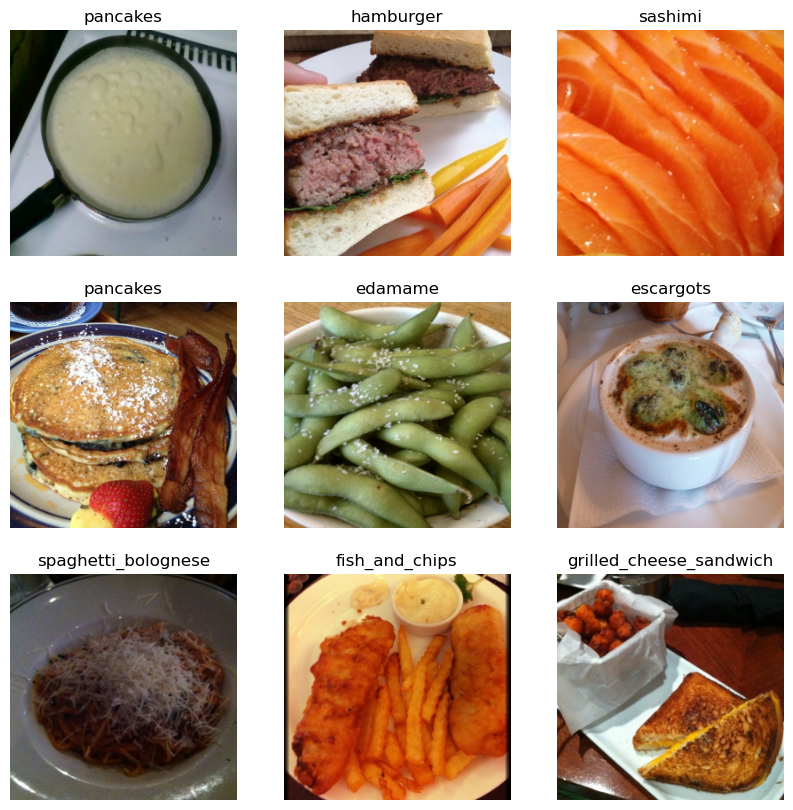

In [6]:
labels = sorted(os.listdir(DATA_FOLDER))

plt.figure(figsize=(10,10))

for (batch_of_images, batch_of_labels) in train_ds.take(1):
    batch_of_images = batch_of_images[:9]
    batch_of_labels = batch_of_labels[:9]
    for i, (image, inferred_label) in enumerate(zip(batch_of_images, batch_of_labels)):
        image = image / 255
        label = labels[np.nonzero(np.array(inferred_label))[0][0]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

## EfficientNetV2B0

### Using ConvNext "as is"

In [7]:
efficient_net = keras.applications.EfficientNetV2B0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
    include_preprocessing=False)  # Do not include the ImageNet classifier at the top.

efficient_net.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                 

In [8]:
def create_transferred_model(base_model):
    base_model.trainable = False   # 🔫👮‍♂️ Freezing the base model

    inputs = keras.Input(shape=(256, 256, 3), batch_size=BATCH_SIZE)
    scaled = keras.layers.Rescaling(scale=1./255.)(inputs) 
    
    x_base = base_model(scaled, training=False)
    gap_layer = keras.layers.GlobalAveragePooling2D()(x_base)
    
    outputs = keras.layers.Dense(101, activation="softmax")(gap_layer)
    return keras.models.Model(inputs, outputs)


In [9]:
transferred_model = create_transferred_model(efficient_net)
transferred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(16, 256, 256, 3)]       0         
                                                                 
 rescaling (Rescaling)       (16, 256, 256, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (16, 1280)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (16, 101)                 129381    
                                                                 
Total params: 6,048,693
Trainable params: 129,381
Non-trainab

Trying it without training

In [10]:
without_training = create_transferred_model(efficient_net)
without_training.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
without_training.evaluate(validation_ds)

2023-05-30 13:14:41.006945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2020]
	 [[{{node Placeholder/_0}}]]
2023-05-30 13:14:41.007152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2020]
	 [[{{node Placeholder/_4}}]]
2023-05-30 13:14:43.784313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901


64/64 [==============================] - 18s 159ms/step - loss: 4.7109 - categorical_accuracy: 0.0089


[4.710883617401123, 0.0089108906686306]

Epoch 1/25


2023-05-30 13:14:58.600097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8080]
	 [[{{node Placeholder/_0}}]]
2023-05-30 13:14:58.600474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8080]
	 [[{{node Placeholder/_4}}]]
2023-05-30 13:15:03.501608: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1d617f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-30 13:15:03.501655: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GT

  1/253 [..............................] - ETA: 22:28 - loss: 4.7175 - categorical_accuracy: 0.0625

2023-05-30 13:15:03.824028: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


253/253 [==============================] - 53s 188ms/step - loss: 3.3580 - categorical_accuracy: 0.2750 - val_loss: 2.6727 - val_categorical_accuracy: 0.3995
Epoch 2/25
253/253 [==============================] - 45s 178ms/step - loss: 2.2123 - categorical_accuracy: 0.4974 - val_loss: 2.3224 - val_categorical_accuracy: 0.4520
Epoch 3/25
253/253 [==============================] - 46s 182ms/step - loss: 1.8116 - categorical_accuracy: 0.5839 - val_loss: 2.1761 - val_categorical_accuracy: 0.4698
Epoch 4/25
253/253 [==============================] - 46s 181ms/step - loss: 1.5620 - categorical_accuracy: 0.6392 - val_loss: 2.0946 - val_categorical_accuracy: 0.4837
Epoch 5/25
253/253 [==============================] - 46s 183ms/step - loss: 1.3799 - categorical_accuracy: 0.6829 - val_loss: 2.0552 - val_categorical_accuracy: 0.4901
Epoch 6/25
253/253 [==============================] - 46s 181ms/step - loss: 1.2344 - categorical_accuracy: 0.7218 - val_loss: 2.0210 - val_categorical_accuracy: 0.49

2023-05-30 13:34:58.429026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,64,32]
	 [[{{node inputs}}]]
2023-05-30 13:34:58.467462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,48]
	 [[{{node inputs}}]]
2023-05-30 13:34:58.493962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-0

INFO:tensorflow:Assets written to: ../models/Transfer learning model/assets


INFO:tensorflow:Assets written to: ../models/Transfer learning model/assets


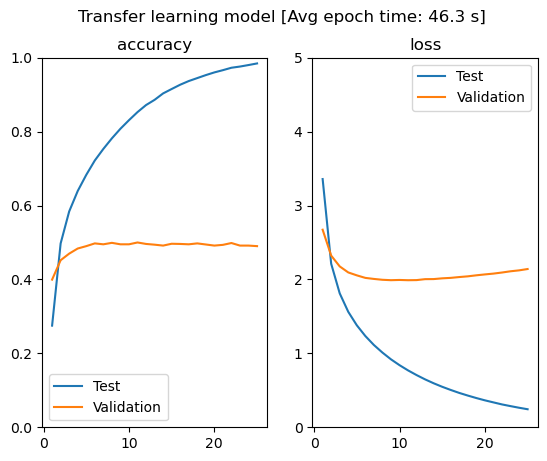

In [11]:
train_and_check_model(transferred_model, "Transfer learning model", t_ds=train_ds, v_ds=validation_ds, epochs=20)

In [12]:
def fine_tune(model_after_transfer_learning):
    base_model_idx = 2
    base_model = model_after_transfer_learning.get_layer(index=base_model_idx)
    base_model.trainable = True

    train_and_check_model(model_after_transfer_learning, 
                          "Fine tuned ConvNeXt", 
                          t_ds=train_ds, 
                          v_ds=validation_ds, 
                          epochs=5, lr_scale=0.01)


fine_tune(transferred_model)

Epoch 1/5
253/253 [==============================] - 194s 607ms/step - loss: 0.1455 - categorical_accuracy: 0.9854 - val_loss: 2.3994 - val_categorical_accuracy: 0.5010
Epoch 2/5
253/253 [==============================] - 150s 592ms/step - loss: 0.0916 - categorical_accuracy: 0.9900 - val_loss: 2.5298 - val_categorical_accuracy: 0.5015
Epoch 3/5
253/253 [==============================] - 150s 593ms/step - loss: 0.0614 - categorical_accuracy: 0.9968 - val_loss: 2.6506 - val_categorical_accuracy: 0.4985
Epoch 4/5
253/253 [==============================] - 150s 593ms/step - loss: 0.0421 - categorical_accuracy: 0.9984 - val_loss: 2.7580 - val_categorical_accuracy: 0.4990
Epoch 5/5
171/253 [===================>..........] - ETA: 45s - loss: 0.0307 - categorical_accuracy: 0.9996

## Szybkie notki - do wywalenia w wersji finalnej

  1. Tensorflow wymaga sporo czasu na zasetapowanie, warto założyć, że spokojnie zajmie to jakieś 2 h dla sprzętu bez zainstalowanych sterowników
  2. Wybrany dataset jest całkiem fajny jeżeli chodzi o transfer learning i fine_tuning, bo ma okropnie brzydkie zdjęcia, często poodwracane i źle skadrowane. Jedyny minus, to że jest ich dużo - napisałem skrypt `trim_dataset.py`, który przekopiowuje z folderu głównego zdjęcia na mniejszy dataset z ustaloną liczbą zdjęć per klasa (ja testowałem początkowo na 50, później zwiększyłem do 100).
  3. Zgodnie z przewidywaniami - zbiór danch nie pokrywa się pod względem klas z imagenetem. Dowód: estymacja nieuczonego modelu na zbiorze walidacyjnym dla food_101 wynosi mniej więcej 1/liczba klas.
  4. Kolejne ułatwienie - można nieco zmniejszyć liczbę klas o połowę albo 3/4. Dzięki temu dużo łatwiej jest trenować sieć przy transfer learningu. Jedyne, o co można się martwić, to że wyniki dla niektórych modeli będą zbyt dobre.
  5. Testowane przeze mnie sieci to **`convNext Tiny`** (który nie jest tak *tiny* jak się wydaje) i **`eficientNetV2B0`**. 
     - Convnext` miał słabe wyniki (max 20% poprawności przy raptem 20 klasach) z szbyką, niemal natychmiastową stagnacją, a do tego uczył się bardzo długo. Przy fine-tuningu rzucił OOM i nawet przy batchu 1 nie dało rady tego poprawić. Wyrzuciłem póki co jego dane z uczenia się ze względu na rzeczony OOM, jednak zapewne jest to do odpalenia na lepszej maszynce bądź przy odmrożeniu kilku warstw.
     - `EfficientNet` uczy się szybko, szybko też się przeucza. Przy fine-tuningu po 5 epokach osiągnął 100% accuracy. Przy transferlearningu też jakieś 25 epok wystarcza, by zobaczyć regres na zbiorze walidacyjnym. **Być może dropout przed warstwą gęstą byłby dobrym rozwiązaniem**

  6. Jakieś inne architektury sieci dostępne w kerasie są wymienione [tutaj](https://keras.io/api/applications/). Z mniejszych niż efficientNet zostały już chyba tylko mobilne. Może te też warto sprawdzić?
  7. Można transfer learning i fine-tuning sprawdzić jeszcze pod kątem:
    -  różnych danych (różna liczba klas oraz klas per funkcja)
    -  zastosowania dropoutu
    - różnych architektur

  8. Możliwe ulepszenia:
     - pokazać, dla jakich zdjęć sieć się myli, a dla jakich nie
     - zrobić własne zdjęcie i sprawdzić, czy dany model ogarnie :3
     - narysować ładniejsze wykresy
  9. Jak się zrobi folder o nazwie `model`, to ten notebook zapisze wytrenowany model. To bardzo dobry checkpoint.